## Project name: Flag Database Fun Time

### Team Leader: Cole Polychronis

### Team Members: Merritt Ruthrauff, Kelsey Henrichsen, Jasmine Boonyakiti

#### Data Description:

Our original datasets has 194 records. We added an additional 13 countries formed after 1990 in order to test the accuracy of our model. Each record is described by these values:

**Response Variable：**
* Religion of a Country      

**Predictor Variables:**
1. Name of country   
2. Continent of country                  
3. Quadrant of the world (relative to Greenwich and the Equator)   
4. Area (in millions of square kilometers)                           
5. Population (in millions) 
6. Language spoken  
7. Number of vertical bars on flag              
8. Number of horizontal stripes on flag         
9. Number of colors on flag    
10. Presence of red on flag
11. Presence of green on flag
12. Presence of blue on flag
13. Presence of gold on flag
14. Presence of white on flag
15. Presence of black on flag
16. Presence of orange on flag
17. Main color on flag
18. Number of circles on flag
19. Number of crosses on flag
20. Number of saltires (diagonal crosses) on flag
21. Number of quartered sections
22. Number of suns or stars on flag
23. Presence of crescent on flag
24. Presence of triangles on flag
25. Presence of inanimate icon on flag
26. Presence of animate icon on flag
27. Presence of text on flag
28. Color in top left of flag
29. Color in bottom right of flag

In [1]:
# load all necessary imported libraries
from lxml import html
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats.kde import gaussian_kde
import warnings
from sklearn import tree as treeClass
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import cross_val_score
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from bokeh.charts import BoxPlot, output_file, show
from sklearn.metrics import confusion_matrix
import seaborn as sn

# Step 1.1: Load Data

Because our data could not be downloaded from the UCI site, we created a very basic webcrawler to pull the dataset off of the UCI page. Since this gave us a list where some attributes were connected by \n, we built a function to seperate these connected values. We then grouped these attributes together into the correct number of rows and converted them into a dataframe.

## <span style="color:blue"> Update for Step 3: Adding Data to Test our Model </span>

In order to test the efficiency of the model that we developed for Step 2, we added 13 additional countries. These countries were founded/formed after the dataset we use was created (1990). 

In [2]:
# basic HTML Scraper to peel data off of UCI webpage
page = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/flags/flag.data')
tree = html.fromstring(page.text)
info = tree.xpath('//text()')
info = info[0].split(',')

# method to untangle values connected by \n (EX: 'green\nAlbania')
def untangle(arr):
    untangled = []
    for el in arr:
        try: 
            ind = el.index('\n')
        except ValueError:
            ind = -1
        if ind == -1:
            untangled.append(el)
        else:
            untangled.append(el[:ind])
            untangled.append(el[ind+1:])
    return untangled

# group data into rows and convert to a Dataframe
untangled = untangle(info)
usable = [untangled[i:i + 30] for i in range(0, len(untangled), 30)]
df = pd.DataFrame(usable)

# remove last buffer row, which contains all None
df = df[:-1]
# convert all columns that should be numeric to ints (as they are currently all strings)
indices = []
for i in range(29):
    if i != 0 and i != 17 and i != 28 and i != 29:
        indices.append(i)
df[indices] = df[indices].apply(pd.to_numeric)



df2 = pd.read_csv("./newCountries.csv", header=None)

In [3]:
superdf = pd.concat([df,df2])
sdfCopy = superdf.copy(deep=True)
superdf = pd.get_dummies(superdf, prefix=['continent', 'quadrant', 'language','mainColor','topLeftColor','bottomRightColor'], columns=[1, 2, 5, 17, 28, 29])

In [4]:
superdf.columns=['country','area (thousands of square of km)', 'population (millions)','religion','bars','stripes','numOfColors','red','green','blue','gold','white','black','orange','numOfCircles','numOfCrosses','numOfSaltires','numOfQuarters','numOfSunStars','crescent','triangle','icon','animate','text','inN.America','inS.America','inEurope','inAfrica','inAsia','inOceania','inNE','inSE','inSW','inNW','english','spanish','french','german','slavic','otherIndoEuropean','chinese','arabic','Japanese/Turkish/Finnish/Magyar','other',
            'mainColor_black','mainColor_blue','mainColor_brown','mainColor_gold','mainColor_green','mainColor_orange','mainColor_red','mainColor_white','topLeftColor_black','topLeftColor_blue','topLeftColor_gold','topLeftColor_green','topLeftColor_orange','topLeftColor_red','topLeftColor_white','bottomRightColor_black',
            'bottomRightColor_blue','bottomRightColor_brown',
            'bottomRightColor_gold','bottomRightColor_green',
            'bottomRightColor_orange','bottomRightColor_red',
            'bottomRightColor_white','bottomRightColor_yellow']
religions = {0: 'Catholic',1: 'Other Christian', 2: 'Muslim', 3: 'Buddhist', 4: 'Hindu', 5: 'Ethnic', 6: 'Marxist', 7: 'Other'}
superdf["religion"].replace(religions, inplace=True)
superdf.head()

,country,area (thousands of square of km),population (millions),religion,bars,stripes,numOfColors,red,green,blue,...,topLeftColor_white,bottomRightColor_black,bottomRightColor_blue,bottomRightColor_brown,bottomRightColor_gold,bottomRightColor_green,bottomRightColor_orange,bottomRightColor_red,bottomRightColor_white,bottomRightColor_yellow
0,Afghanistan,648,16,Muslim,0,3,5,1,1,0,...,0,0,0,0,0,1,0,0,0,0
1,Albania,29,3,Marxist,0,0,3,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Algeria,2388,20,Muslim,2,0,3,1,1,0,...,0,0,0,0,0,0,0,0,1,0
3,American-Samoa,0,0,Other Christian,0,0,5,1,0,1,...,0,0,0,0,0,0,0,1,0,0
4,Andorra,0,0,Catholic,3,0,3,1,0,1,...,0,0,0,0,0,0,0,1,0,0


# Step 1.2: Preprocessing
This data is separated into each of the columns that represent the data we are going to analyze for each country. i.e. Area, population, religion, etc. In order to get the categorical variables to work with our dataset, we had to convert them using the .get_dummies to convert the data to use for the DecisionTreeClassifier. In order for the tree to make sense on the graphviz, there needed to be a modification of the column names.

## <span style="color:blue"> Update for Step 3: Realizing the Importance of Normalizing Data </span>
After completing our first iteration through step 2, where our model derived almost 85% of its predictive power from the Population of the country, we realized the importance of normalizing numerical data in our dataset. In order to normalize the data, we took the top 4% of data in each numerical category and converted it to a null value. We then replaced these null values with the mean of each column. The graphs of the data before and after removing outliers are shown below.

In [5]:
m=[superdf['area (thousands of square of km)'].quantile(0.96), superdf['population (millions)'].quantile(0.96), superdf['numOfColors'].quantile(0.96)]

In [6]:
def kde_plot(x):   
    kde = gaussian_kde(x)
    positions = np.linspace(x.min(), x.max())
    smoothed = kde(positions)
    plt.plot(positions, smoothed)
    
def kde_values(x):   
    kde = gaussian_kde(x)
    positions = np.linspace(x.min(), x.max())
    smoothed = kde(positions)
    return positions, smoothed

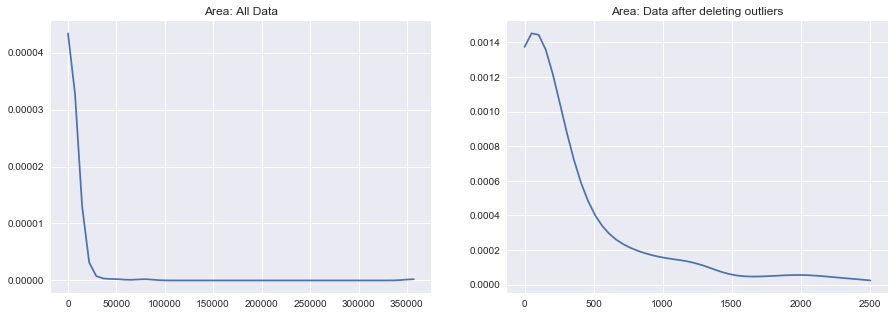

In [7]:
x=superdf['area (thousands of square of km)']
x=x.dropna()

plt.rcParams['figure.figsize'] = (15,5)
f, (ax1, ax2) = plt.subplots(1, 2)
positions, smoothed = kde_values(x)
ax1.plot(positions, smoothed)
ax1.set_title('Area: All Data')
positions, smoothed = kde_values(x[x<2777])
ax2.plot(positions, smoothed)
ax2.set_title('Area: Data after deleting outliers')
plt.show()

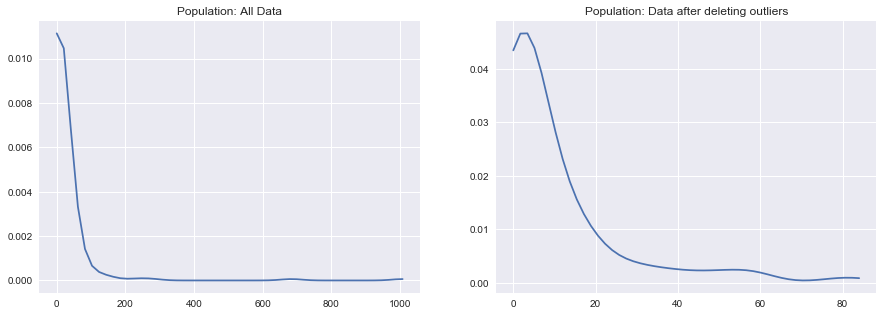

In [8]:
x=superdf['population (millions)']
x=x.dropna()

plt.rcParams['figure.figsize'] = (15,5)
f, (ax1, ax2) = plt.subplots(1, 2)
positions, smoothed = kde_values(x)
ax1.plot(positions, smoothed)
ax1.set_title('Population: All Data')
positions, smoothed = kde_values(x[x<85.68])
ax2.plot(positions, smoothed)
ax2.set_title('Population: Data after deleting outliers')
plt.show()

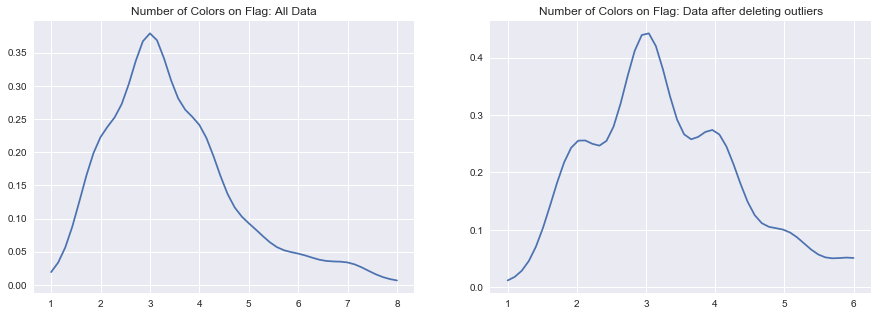

In [9]:
x=superdf['numOfColors']
x=x.dropna()

plt.rcParams['figure.figsize'] = (15,5)
f, (ax1, ax2) = plt.subplots(1, 2)
positions, smoothed = kde_values(x)
ax1.plot(positions, smoothed)
ax1.set_title('Number of Colors on Flag: All Data')
positions, smoothed = kde_values(x[x<6.28])
ax2.plot(positions, smoothed)
ax2.set_title('Number of Colors on Flag: Data after deleting outliers')
plt.show()

In [10]:
superdf['area (thousands of square of km)']=superdf['area (thousands of square of km)'].map(lambda x: None if x>m[0] else x)
superdf['population (millions)']=superdf['population (millions)'].map(lambda x: None if x>m[1] else x)
superdf['numOfColors']=superdf['numOfColors'].map(lambda x: None if x>m[2] else x)
superdf = superdf.fillna(superdf.mean())

warnings.filterwarnings("ignore", category=DeprecationWarning) 
superdf['area (thousands of square of km)'] = preprocessing.StandardScaler().fit_transform(superdf['area (thousands of square of km)'])
superdf['population (millions)'] = preprocessing.StandardScaler().fit_transform(superdf['population (millions)'])
superdf['numOfColors'] = preprocessing.StandardScaler().fit_transform(superdf['numOfColors'])

## <span style="color:blue"> Update for Step 3: Creating Test Data </span>
In order to test the efficacy of our models developed for step 2, we create data that will be used specifically for testing our model (and not for training it). Based on our observations that we will discuss in greater detail for Step 3 below, we create 2 kernels for training and testing. For the first kernel, we use all of the data from the original UCI dataset as training data and the data that we created from countries formed after 1990 as the testing data. For the second kernel, we use a combination of a portion of the UCI dataset and all of our created data as our training data, and the remaining (unused) portion of the UCI dataset as our testing data.

In [11]:
# dataframe to train models on
df = superdf[0:194]
# dataframe to test models on (new data)
testdf = superdf[195:-1]
# dataframes to show sensitivity to timeframe of our model
df2 = superdf[12:-1]
testdf2 = superdf[0:11]

In [12]:
data_df = df.drop(['country','religion'], axis=1)
target_df = df['religion']

data = data_df.as_matrix()
target = target_df.as_matrix()

# Step 1.3: Modeling using Decision Tree
For this part, we had to put the data that we had created above into the Decision Tree Classifier to finally see the output of the data. Instead of the data being used as whole numbers, the data was converted to percentages to show the importance of each category. With the output given, the population data is the most important feauture when comparing the religion of a country to the rest of the data.

In [13]:
# create Decision Tree Classifier and determine which features are most important
clf = treeClass.DecisionTreeClassifier()
clf.fit(data,target)

y_pred = clf.predict(data)
classif_rate = np.mean(y_pred.ravel() == target.ravel()) * 100
print("classif_rate for %s : %f " % ('RandomForestClassifier', classif_rate))
print clf.feature_importances_

classif_rate for RandomForestClassifier : 100.000000 
[ 0.02370159  0.10536275  0.03868395  0.02125492  0.06101862  0.
  0.02094003  0.          0.00859643  0.          0.01141539  0.02688566
  0.          0.02507293  0.          0.02011044  0.02558462  0.01611831
  0.00583329  0.          0.0219209   0.          0.          0.          0.
  0.09200685  0.07278817  0.          0.01191778  0.          0.00859643
  0.          0.12734025  0.04854566  0.          0.          0.          0.
  0.          0.09931701  0.01074554  0.01968249  0.          0.          0.
  0.          0.          0.          0.          0.01674124  0.00644732
  0.          0.          0.01547358  0.          0.01547358  0.00576866
  0.          0.01665559  0.          0.          0.          0.          0.
  0.          0.        ]


# Step 1.4: Visualization
The final step was to import the graphviz package and use it to take the information and make a tree to display the. The information that is displayed is the decision tree from above (clf), the table that holds the information (feature_names), and the religion from each country (class_names). With the categorical variables such as the inS.America, the value is <= 0.5 which means the value is 0 or not true in this case. When looking at any of the data that has a value of > 0 which makes the value true. 

***Note: The Decision Tree produced by this model is large, so you may have to scroll around some to start seeing the branches of the tree.**

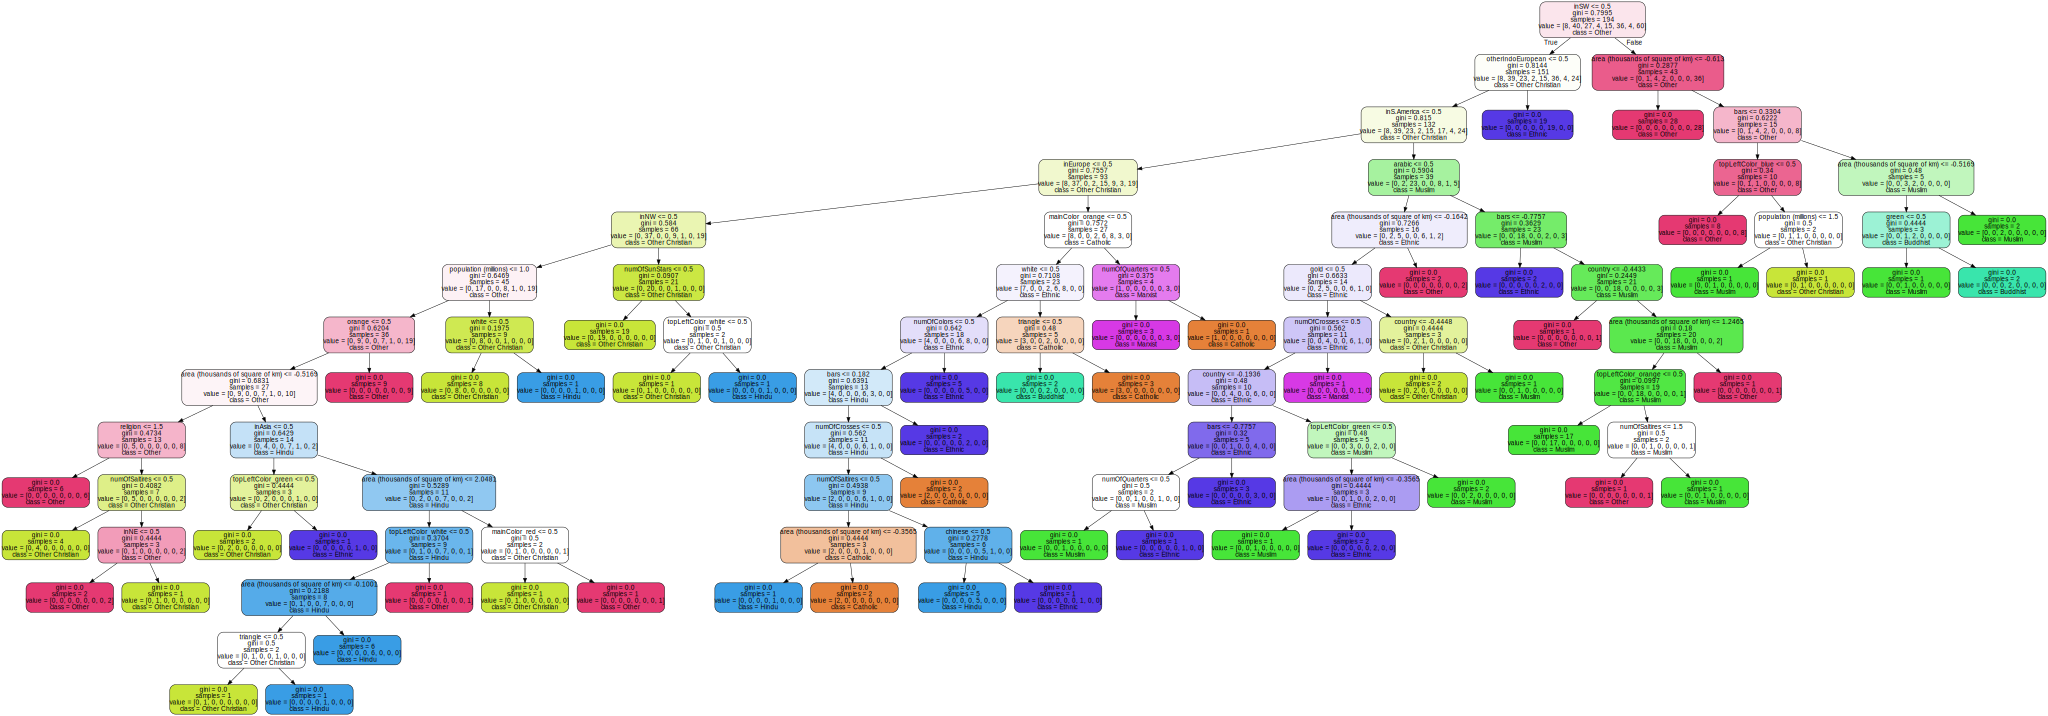

In [14]:
# visualize the decision tree
import graphviz
dot_data = treeClass.export_graphviz(clf, out_file=None,
#                                max_depth=5,
                               filled=True, rounded=True,
                               feature_names=df.columns,
                               class_names=['Catholic','Other Christian', 'Muslim', 'Buddhist', 'Hindu', 'Ethnic', 'Marxist', 'Other']) 
graph = graphviz.Source(dot_data)  
graph

# Step 2.1: Model and Parameter Selection
In order to find the best model for our data, and the best parameters to use with that model, we use Grid Search on our choice of five models: a Decision Tree, a Random Forest, a Gradient Boosting Model, a Support Vector Machine, and a Neural Network.

In [15]:
models = [DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), SVC(), MLPClassifier()]
tuned_parameters = [{'max_depth': [None,10,20], 'criterion': ['gini','entropy']}, # parameters for decision tree
                   {'n_estimators':[10,20,30,40], 'max_depth':[None, 10, 20]}, # parameters for random forest
                   {'n_estimators':[10,20,30,40], 'max_depth':[None, 10, 20]}, # parameters for gradient boost
                   {'decision_function_shape':['ovo'], 'degree':[1,2,3,4,5]}, # parameters for support vector machine
                   {'solver': ['lbfgs', 'sgd', 'adam'], 'max_iter': [200, 300, 400]} # parameters for neural network
                   ]
for model, tuned_parameter in zip(models, tuned_parameters):
    classify = GridSearchCV(model,tuned_parameter,cv=4,verbose=1)
    classify.fit(data,target)
    print classify.best_params_
    print classify.best_score_ 

Fitting 4 folds for each of 6 candidates, totalling 24 fits
{'criterion': 'gini', 'max_depth': 10}
0.582474226804
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    4.6s finished


{'n_estimators': 30, 'max_depth': 20}
0.726804123711
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   13.3s finished


{'n_estimators': 40, 'max_depth': 10}
0.60824742268
Fitting 4 folds for each of 5 candidates, totalling 20 fits
{'decision_function_shape': 'ovo', 'degree': 1}
0.561855670103
Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished
/Users/colepolychronis/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



{'max_iter': 200, 'solver': 'adam'}
0.644329896907


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    5.4s finished


# Step 2.2: Model Evaluation
After we determined the Random Forest Classifier with a max_depth of 20 and 30 estimators to be our best model, we move on to testing its accuracy in predicting the religion of a country. We use K-Fold Cross-Validation to test on average, how accurately our model is able to predict the religion of a country using 4/5 of the data to train on. We found that our model has an average accuracy of 70% +/- 8%.

In [16]:
classify = RandomForestClassifier(n_estimators = 40, max_depth = None)
classify.fit(data,target)

y_pred = classify.predict(data)
classif_rate = np.mean(np.equal(y_pred.ravel(), target.ravel())) * 100

In [17]:
dec = RandomForestClassifier(n_estimators = 40, max_depth = None, criterion='gini')
scores = cross_val_score(dec, data, target, cv=4)
print("Model Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Model Accuracy: 0.71 (+/- 0.11)


## Visualization using Matplotlib
## <span style="color:blue"> Update for Step 3: More Reasonable Feature Importances </span>

Here, we use the Matploblib Library to visualize which features are most important to our model in determining the religion of a country. In stark contrast to our original graph of these feature importances, which suggested that the population of a country had almost an 85% weight in determining the religion of a country, we now see a more reasonable spread. While Population is still clearly an important according to our graph below, we can see that the area of the country is almost equally important. We can also see that things that should be slighly indicative of religion, such as language, the continent that the country resides in, and even some flag features such as presence of suns, stars, and crosses (all of which are pretty religously symbolic), begin to play a role in predicting religion. 

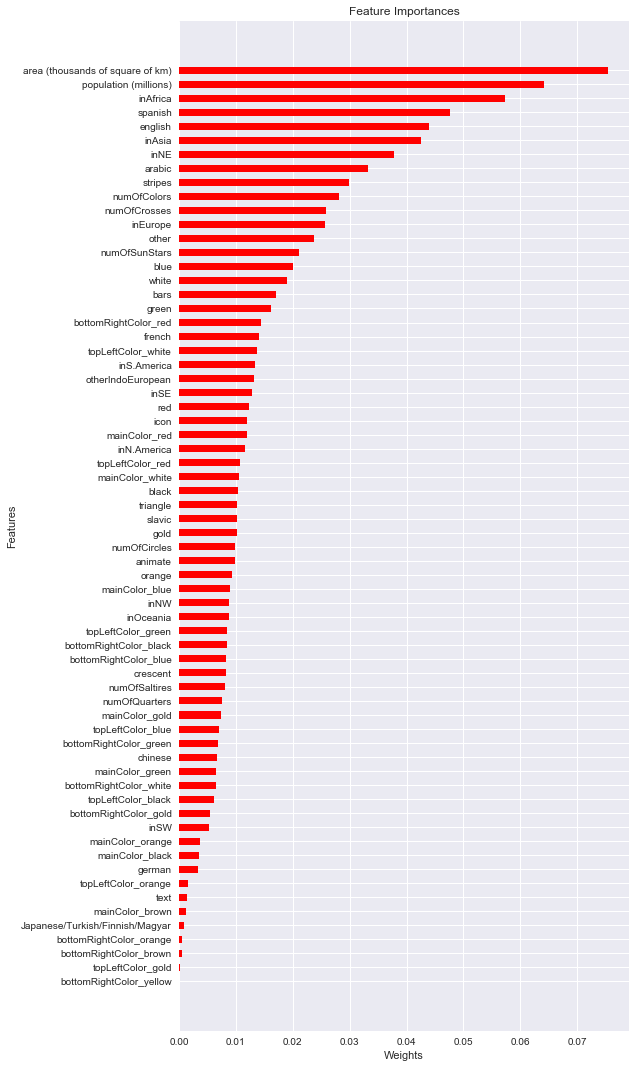

In [18]:
features= data_df.columns.values
value = classify.feature_importances_
ind=sorted(range(len(value)),reverse=False,key=lambda k: value[k])
features=features[ind]
value=sorted(value,reverse=False)
ind=np.array(range(len(features)))
plt.rcParams['figure.figsize'] = (9,15)
plt.barh(bottom=ind,height=0.5,width=value,color='r')
plt.yticks(ind,features)
plt.xlabel('Weights')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

## Visualization using Plotly
## <span style="color:blue"> Update for Step 3: Exploring Area and Population </span>

In light of the new set of feature importances that we visualized above, we believed it would be beneficial to take a closer look at Area and Population. To do this, we use the Plotly Library and Platform to visualize the Scatterplot of Area vs. Population. The benefit of having this plot be interactive is that we can explore different clusters of data. For example, clicking and dragging to view the window of Area between -1 and 4, and Population between -1 and 4, allows us to see that a significant number of Muslim countries can be found on the "outer band", which suggests that Muslim countries are larger in area and tend to be populated by more people. Likewise, clicking and dragging to view the window of Area between -1 and 1, and Population between -1 and 0, we can see that a large number of Ethnically religious countries can be found in the innermost "band" or cluster, which indicates that Ethnic countries tend to be smaller in area and populated by less people.

In [19]:
fig = {
    'data': [
        {
            'x': df[df['religion']==religion]['population (millions)'],
            'y': df[df['religion']==religion]['area (thousands of square of km)'],
            'name': religion, 'mode': 'markers',
        } for religion in ['Catholic','Other Christian', 'Muslim', 'Buddhist', 'Hindu', 'Ethnic', 'Marxist', 'Other']
    ],
    'layout': {
        'title': 'Area vs. Population grouped by Religion',
        'xaxis': {'title': 'Population (normalized)'},
        'yaxis': {'title': "Area (normalized)"}
    }
}
py.iplot(fig, filename='Area vs Population grouped by Religion')

## Visualizations using Bokeh
## <span style="color:blue"> Update for Step 3: Taking a Closer Look at Area and Population </span>
Considering that they were our most important features, we felt that it was warranted to spend a little more time exploring the area and population features of our dataset. To do so, we used the Bokeh Library to visualize the boxplots of both area and population. Using side-by-side boxplots specifically is helpful because it allows us to simulatenously compare spread and center of each one of the religous groups in terms of area and religion. 

In regards to area, we can see that the "Other" and "Other Christian" categories are the most tightly grouped, which indicates that prediction of these religions might be more accurate. Compare this with the Muslim and Hindu groups, which are both significantly spread out, especially for the upper quantiles. This might indicate that predictions for these religions are slightly less accurate. We can also see that by far, the "Other Chrisitian" group has the largest number of outliers, also possibly decreasing accuracy for these predictions.

In regards to population, we can see that there is significantly less difference in the spread between groups, with Buddhist, Muslim, and "Other" countries being slightly more spread out than the others, but not by much. However, we can see that the Muslim and "Other Christian" countries have significantly more outliers than the rest of the groups, once again raising the concern that predicition of these religions might be slightly less accurate.

***Note: These visualizations are rendered on different web pages**

In [20]:
box = BoxPlot(df, values='population (millions)', label='religion', color='religion', title='Distribution of Population by Religion', width=600)

output_file('box.html')
show(box)

In [21]:
box = BoxPlot(df, values='area (thousands of square of km)', label='religion', color='religion', title='Distribution of Population by Religion', width=600)

output_file('box.html')
show(box)

# Step 3.1: Predicting on our Generated Data
Below, we use our optimal model of a Random Forest Classifier to predict the religion of the data we generated based on countries that were formed after our dataset was created (in 1990). As can be seen from the first of our prediction accuracies below, when we train on the UCI data and test on our generated data, we have less accuracy than a random coin flip, which means that our model is meaningless. More interesting, however, is the second of our prediction accuracies, where we train on a combination of a portion of the UCI dataset and all of our generated data and test on the remaining (unused) portion of the UCI dataset, where our accuracy is close to 90%. This seems to suggest that while our model is terrible for predicting religion for moden day countries, it is a powerful model for predicting religion of countries pre-1990. We explore this graphically below.

In [22]:
newData = testdf.drop(['country','religion'], axis=1).as_matrix()
newTarget = testdf['religion'].as_matrix()

In [23]:
predictor = RandomForestClassifier(n_estimators = 40, max_depth = None)
predictor.fit(data,target)

yhat=predictor.predict(newData)
print 'Prediction Accuracy for Kernel 1 Data (Testing on our generated data)'
print accuracy_score(newTarget,yhat) 

Prediction Accuracy for Kernel 1 Data (Testing on our generated data)
0.25


In [24]:
data2 = df2.drop(['country','religion'], axis=1).as_matrix()
target2 = df2['religion']

newData2 = testdf2.drop(['country','religion'], axis=1).as_matrix()
newTarget2 = testdf2['religion']

In [25]:
predictor2 = RandomForestClassifier(n_estimators = 40, max_depth = None)
predictor2.fit(data2,target2)

yhat2=predictor2.predict(newData2)
print 'Prediction Accuracy for Kernel 2 Data (Testing on our unused portion of UCI data)'
print accuracy_score(newTarget2,yhat2) 

Prediction Accuracy for Kernel 2 Data (Testing on our unused portion of UCI data)
0.909090909091


## Visualization using Seaborn
## <span style="color:blue"> Update for Step 3: Analyzing Accuracy of Our Model on Different Datasets </span>
Here, we use the Seaborn Library to visualize the confusion matrices of our model when training it and testing it on Kernel 1 data versus Kernel 2 data. In essence, the confusion matrices below allow us to see how well our model performs by comparing the religion preddicted by our model against the actual religion of a country. More importanly, however, is the fact that confusion matrices can offer some insight into how specifically our model predicts/is failing to predict religion. For example, the confusion matrix on the left, which corresponds to our Kernel 1 data, demonstrates that our model was only able to accurately predict the ethnic countries well. Of the 8 countries our model incorrectly predicted, it predicted the religion to be Muslim for 4 of them. This could tie back to our concern address earlier in the Bokeh plots, which seemed to indicate that there was a lot of spread in terms of the data for Muslim countries in terms of Area and Population (our two most important features). This could be indicative that our model is overfitting. However, when we consider the confusion matrix on the right, which is trained on data according to Kernel 2, it seems to indicate that perhaps overfitting is not the problem and that instead, our model is fairly accurate for predicting the religion of countries that existed during the 1990's, but is less accurate for the countries that formed post-1990.

In [26]:
cm1 = confusion_matrix(newTarget, yhat)
df_cm1 = pd.DataFrame(cm1, index = [i for i in ['Catholic','Other Christian', 'Muslim', 'Buddhist', 'Ethnic', 'Marxist']],
                  columns = [i for i in ['Catholic','Other Christian', 'Muslim', 'Buddhist', 'Ethnic', 'Marxist']])

cm2 = confusion_matrix(newTarget2, yhat2)
df_cm2 = pd.DataFrame(cm2, index = [i for i in ['Catholic','Other Christian', 'Muslim', 'Ethnic', 'Marxist']],
                  columns = [i for i in ['Catholic','Other Christian', 'Muslim', 'Ethnic', 'Marxist']])

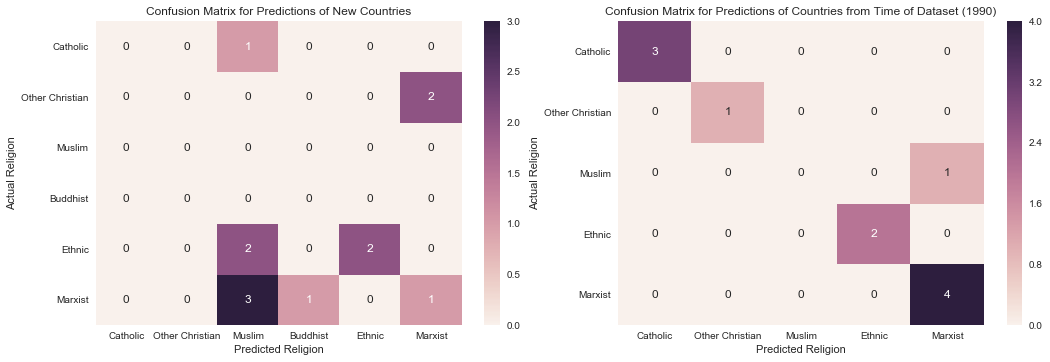

In [29]:
plt.rcParams['figure.figsize'] = (15,5)
fig, (ax1, ax2) = plt.subplots(1, 2)

sn.heatmap(df_cm1, annot=True, ax=ax1).set_title('Confusion Matrix for Predictions of New Countries')
sn.heatmap(df_cm2, annot=True, ax=ax2).set_title('Confusion Matrix for Predictions of Countries from Time of Dataset (1990)')

fig.tight_layout()
ax1.set_xlabel("Predicted Religion")
ax1.set_ylabel("Actual Religion")
ax2.set_xlabel("Predicted Religion")
ax2.set_ylabel("Actual Religion")

plt.show()